# **Assignment 3**

Parsa Youssefpour

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install pyvirtualdisplay
!sudo apt-get install xvfb

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import random
import csv
import time

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---
##**Exercise 1: Prelims**

In [ ]:
#test the enviroment with random sampeling
env = gym.make('MountainCar-v0')
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

In [ ]:
print(env.observation_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [ ]:
stateSpaceSize = env.observation_space
print(stateSpaceSize)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [ ]:
#number of possible actions
a = env.action_space
print(a.n)

3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
### Common functions used in all algorithms

In [ ]:
#decreasing the number of states and turning them into tuple to use as dict key
def create_state(observation):
  #rounding the state values in the observation, to reduce the number of states
  formatted_list = [ '%.2f' % elem for elem in observation ]
  return tuple(formatted_list)

# Visualize the decrived policy by applying it to the problem
# Using a policy that is greedy w.r.t. the inputted Q
def Test_performace(Q):
  env = gym.make('MountainCar-v0', max_episode_steps=500)
  obs = env.reset()
  prev_screen = env.render(mode='rgb_array')
  plt.imshow(prev_screen)

  for i in range(50000):
    state = create_state(obs)
    action = np.argmax(Q[state])
    print("step i",i,"action=",action)
    obs, reward, done, info = env.step(action)
    print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      break

  ipythondisplay.clear_output(wait=True)
  env.close()
  print("Iterations that were run:",i)


#moving average to denoise the learning curve
def moving_average(data, window_size):
    if window_size <= 0:
        raise ValueError("Window size should be a positive integer")
    if window_size > len(data):
        raise ValueError("Window size should not exceed the length of the data")

    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        avg = sum(window) / window_size
        moving_averages.append(avg)

    return moving_averages


#graph the learning curve (reward vs epiosode)
def graph_performance(rewards):
  #taking a moving average to denoise the data
  result = moving_average(rewards,2000)
  x = range(len(result))
  y = result

  plt.scatter(x,y, color = "b", marker='.', s=5)
  a, b = np.polyfit(x, y, 1)                        # get the line of bestfit
  plt.plot(x, a*x+b, color = "r")                   # plot the line of besfit
  plt.xlabel("Episodes")
  plt.ylabel("Rewards")
  plt.show()
  print(f"line of best fit equation: {round(a,4)}x + {round(b,4)}")

###**MC Controller**

In [ ]:
#initializing q
q={}
#initializing e-greedy
e_policy = {}
#returns dict used to store G values per state-action pair
returns = {}
#used to record how many times each state and action has been visited to take an average of the returns
number_visited = {}

def policy(state, epsilon):
  #initiating a new state with random values
  if state not in q.keys():
    q[state] = [0,0,0]
    e_policy[state] = [0.33,0.33,0.33]

  best_prob = 1-epsilon + epsilon/3
  other_prob = epsilon/3

  # e-greedy policy
  for i in range(len(e_policy[state])):
    if i == np.argmax(q[state]):
      e_policy[state][i] = best_prob
    else:
      e_policy[state][i] = other_prob

  return np.random.choice(range(len(e_policy[state])), p=e_policy[state])


#updating q
def update_q(episode , gamma):

  #creating a list with all the state action pairs experieced during the episode
  state_action_visited = [(state, action) for (state, action, reward) in episode]

  # creating a list of rewards per state action pairs
  rewards = [reward for (state, action, reward) in episode]

  #initialising G
  G = 0

  # all_rewards.append(sum(rewards))

  #looping through the state action pairs in the episode to update the q
  for t in range(len(episode)-1):
    (state, action, reward) = episode[t]
    G = gamma * G + rewards[t+1]

    # first visit monte carlo
    if (state, action) not in state_action_visited[:t]:
      if (state,action) in returns.keys():
        returns[(state,action)] += G
        number_visited[(state, action)] +=1
      else:
        returns[(state,action)] = G
        number_visited[(state, action)] =1

      #taking average of return values to update the q for each state action pair
      q[state][action] = returns[(state,action)]/ number_visited[(state,action)]



#generate an episode, until the cartpole fails
def generate_episode(obs, epsilon):
  episode = []
  done = False
  total_rewards = 0
  while not done:
    state = create_state(obs)
    action = policy(state, epsilon)
    obs, reward, done, info = env.step(action)
    total_rewards += reward
    state = create_state(obs)
    episode.append((state, action, reward))

  return episode, total_rewards


#generating and updating multiple epsiodes and q
def MC(gamma, epsilon, epoch):
  #initialize list to store rewards per episode
  R = []
  for i in range(epoch):
    obs = env.reset()
    #generating and episode
    episode, total_rewards = generate_episode(obs, epsilon = epsilon)
    #updating the q values based on the generated episode
    update_q(episode, gamma = gamma)
    # add epsiodes rewards to the list
    R.append(total_rewards)

    # print after evey 10,000 episode
    if i % 10_000 == 0:
        print(f"Episode {i}")

  return q, R


In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_MC , MC_reward= MC(gamma = 0.9,epsilon = 0.25, epoch = 100_000)
end_time = time.time()
print("Elapsed Time: ", end_time - start_time)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Episode 60000
Episode 70000
Episode 80000
Episode 90000
Elapsed Time:  2692.203830242157


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


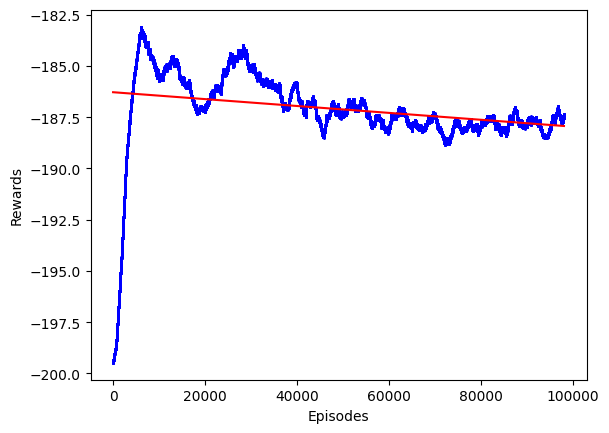

line of best fit equation: -0.0x + -186.2838
Average rewards:  -187.2427


In [ ]:
#Learning Curve
graph_performance(MC_reward)
print("Average rewards: ", np.mean(MC_reward))

Iterations that were run: 199


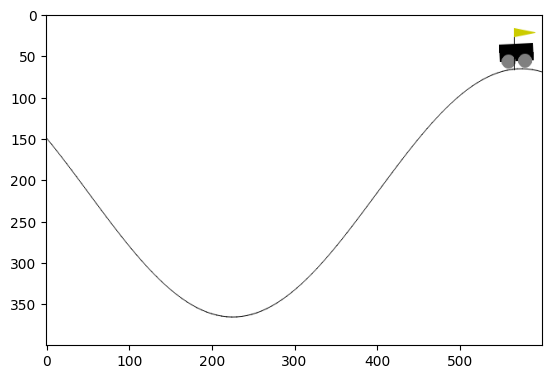

In [ ]:
#Testing the learned policy
Test_performace(Q_MC)

---

## **Task 1: TD(0)**

###**On-policy SARSA Controller**

In [ ]:
#e-greedy policy
def SARSA_Policy(state,epsilon,Q, pi):
  if state not in Q.keys():
    Q[state] = [0,0,0]
    pi[state] = [0.33,0.33,0.33]

  best_prob = 1-epsilon + epsilon/3
  other_prob = epsilon/3

  # e-greedy policy
  for i in range(len(pi[state])):
    if i == np.argmax(Q[state]):
      pi[state][i] = best_prob
    else:
      pi[state][i] = other_prob

  return np.random.choice(range(len(pi[state])), p=pi[state])

#SARSA Function
def SARSA(alpha, gamma, epoch, epsilon):
    #initializing relavent dicts and lists
    Q = {}
    e_policy = {}
    rewards = []
    for i in range(1,epoch+1):
      obs = env.reset()
      done = False
      state = create_state(obs)
      action = SARSA_Policy(state, epsilon = epsilon, Q=Q, pi=e_policy)
      # initialize reward per episode
      total_reward = 0

      while not done:
        obs, reward, done, info = env.step(action)
        total_reward += reward
        next_state = create_state(obs)
        next_action = SARSA_Policy(next_state, epsilon = epsilon, Q=Q, pi = e_policy)

        Q[state][action] += alpha*(reward + gamma*Q[next_state][next_action] - Q[state][action])

        state = next_state
        action = next_action

      #adding rewards per episode to the rewards list
      rewards.append(total_reward)

      if i % 10_000 == 0:
        print(f"Episode {i}")

    return Q, rewards

In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_SARSA, SARSA_rewards = SARSA(alpha = 0.15,gamma = 0.9,epoch = 50_000, epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1228.29 s


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


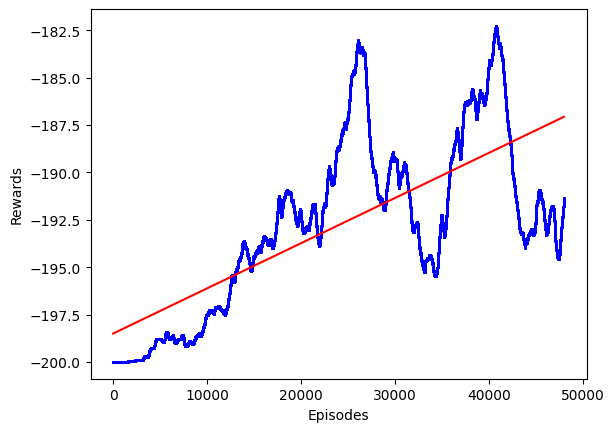

line of best fit equation: 0.0002x + -198.5038
Average rewards:  -192.8756


In [ ]:
#Learning Curve
graph_performance(SARSA_rewards)
print("Average rewards: ", np.mean(SARSA_rewards))

Iterations that were run: 156


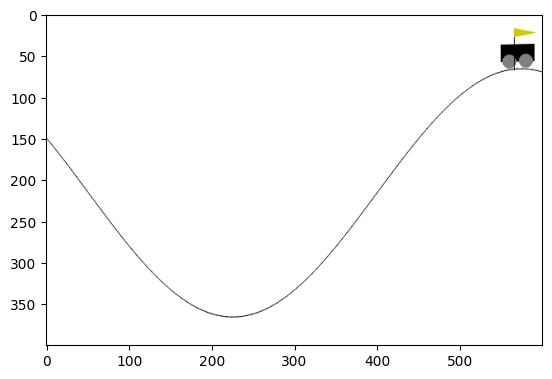

In [ ]:
#Testing the Learned Policy
Test_performace(Q_SARSA)

---

###**On Policy Expected SARSA**

In [ ]:
#e-greedy policy
def ESARSA_policy(state,Q,pi,epsilon):
  if state not in Q.keys():
    Q[state] = [0,0,0]
    pi[state] = [0.33,0.33,0.33]

  best_prob = 1-epsilon + epsilon/3
  other_prob = epsilon/3

  # e-greedy policy
  for i in range(len(pi[state])):
    if i == np.argmax(Q[state]):
      pi[state][i] = best_prob
    else:
      pi[state][i] = other_prob

  return np.random.choice(range(len(pi[state])), p=pi[state])

#Ecpected SARSA Function
def Expected_Sarsa_Learning(alpha, gamma, epoch, epsilon):
  Q = {}
  policy={}
  rewards=[]
  for i in range(1,epoch+1):
      obs = env.reset()                                                         # initialize S
      done = False
      state = create_state(obs)
      action = ESARSA_policy(state,Q,policy,epsilon)                            # choose A from S

      # initialize reward per episode
      total_rewards = 0

      while not done:
        obs, reward, done, info = env.step(action)                              # observe R, S'
        #summing the rewards within an episode
        total_rewards += reward
        next_state = create_state(obs)
        next_action = ESARSA_policy(next_state,Q,policy,epsilon)                # choose A'

        Q_target=0
        for a in range(len(Q[next_state])):
          Q_target += policy[next_state][a]*Q[next_state][a]                    # Get Q_target, weighted sum of Q values wrt. target policy

        Q[state][action] += alpha*(reward + gamma*Q_target - Q[state][action])    #update Q

        #update action and state
        state = next_state
        action = next_action

      #adding the epiode rewards to the reward list
      rewards.append(total_rewards)

      if i % 10_000 == 0:
        print(f"Episode {i}")

  return Q , rewards


In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_ESARSA, ESARSA_rewards = Expected_Sarsa_Learning(alpha = 0.1,gamma = 0.9,epoch = 50_000, epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1235.87 s


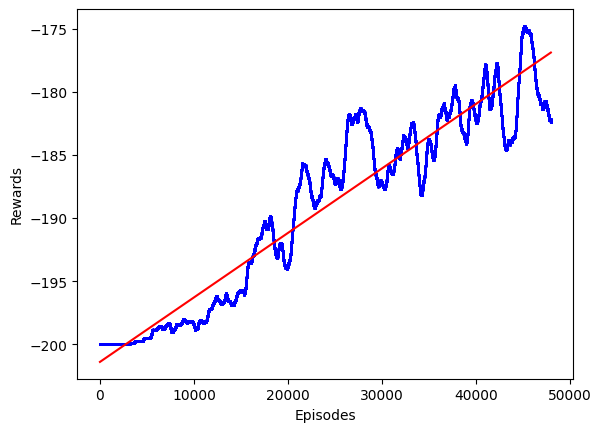

line of best fit equation: 0.0005x + -201.392
Average rewards:  -189.23732


In [ ]:
#Learning Curve
graph_performance(ESARSA_rewards)
print("Average rewards: ", np.mean(ESARSA_rewards))

Iterations that were run: 171


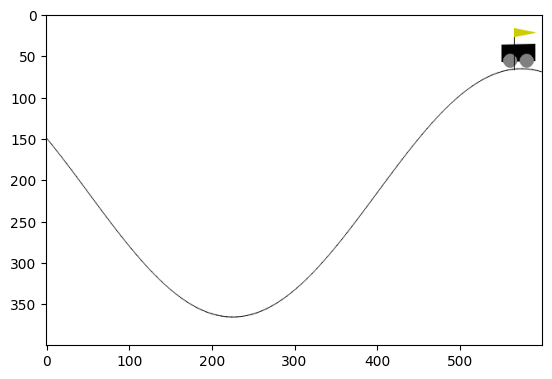

In [ ]:
#Testing the Learned Policy
Test_performace(Q_ESARSA)

---

###**off-policy expected SARSA with a greedy control policy**

When behavior policy is greedy expected SARSA is identical to Q Learning

In [ ]:
#e-greedy policy
def Q_policy(state, Q, pi, epsilon):
  if state not in Q.keys():
    Q[state] = [0,0,0]
    pi[state] = [0.33,0.33,0.33]

  best_prob = 1-epsilon + epsilon/3
  other_prob = epsilon/3

  # e-greedy policy
  for i in range(len(pi[state])):
    if i == np.argmax(Q[state]):
      pi[state][i] = best_prob
    else:
      pi[state][i] = other_prob

  return np.random.choice(range(len(pi[state])), p=pi[state])

#Q-learning Function
def Q_learning(alpha, gamma, epoch, epsilon):
  Q = {}
  policy = {}
  rewards = []
  for i in range(1,epoch+1):
      obs = env.reset()
      done = False
      state = create_state(obs)
      total_rewards = 0
      while not done:
        action = Q_policy(state, Q, policy, epsilon)
        obs, reward, done, info = env.step(action)
        total_rewards += reward
        next_state = create_state(obs)
        next_action = Q_policy(next_state, Q, policy, epsilon = epsilon)
        #keep track of the rewards collected in each episode
        Q[state][action] += alpha*(reward + gamma*max(Q[next_state])- Q[state][action])

        state = next_state

      rewards.append(total_rewards)

      if i % 10_000 == 0:
        print(f"Episode {i}")

  return Q, rewards

In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_q, Q_rewards= Q_learning(alpha = 0.1,gamma = 0.9,epoch = 50_000,epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1780.01 s


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


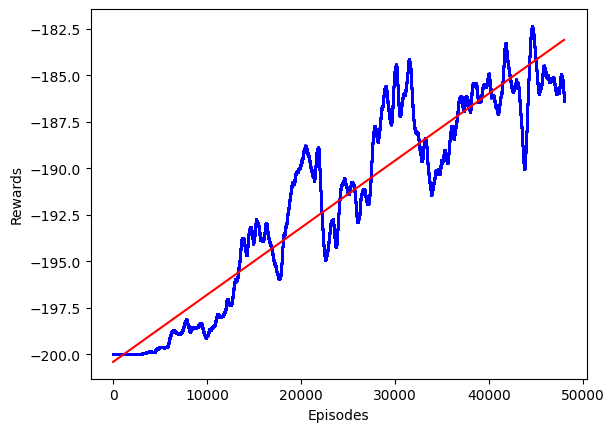

line of best fit equation: 0.0004x + -200.3986
Average rewards:  -191.8428


In [ ]:
Q_rewards = read_r("Q_rewards")
#Learning Curve
graph_performance(Q_rewards)
print("Average rewards: ", np.mean(Q_rewards))

Iterations that were run: 151


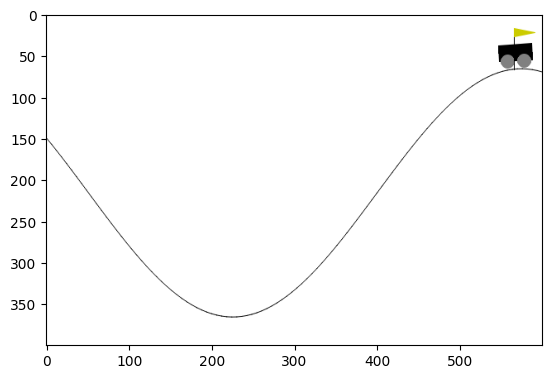

In [ ]:
#Testing the learned policy
Test_performace(Q_q)

### **Comparison/Analysis**

The table below displays the training time, the slope of the line of best fit and the average reward collected during the tarining of the model.
```
Controller | Training Time(s) |   Slope  | Avg reward |
–––––––––––––––––––––––––––––––––––––––––––––––––––––––
MC         |    2692.20       | -0.00001 |   -187.24
           |                  |          |
SARSA      |    1228.29       |  0.0002  |   -192.87
           |                  |          |
ESARSA     |    1235.87       |  0.0005  |   -189.24
           |                  |          |
Q-Learning |    1780.01       |  0.0004  |   -191.84
```


By looking at the time it took to train each agent, SARSA and Expected SARSA, took a similar amount of time to complete the 50,000 epsiodes while Q-learning took around 500s longer.

While Q-learning, SARSA and ESARSA, were able to develope a good policy within 50,000 epochs/episodes, it took MC 100,000 epochs/episodes to learn develope such policy, hence the training time is significantly longer that the other controllers.

Based on the slopes of the lines of best fit, ESARSA experienced the fastest rate of improvement, with Q-learning having the second highest rate of improvement, with MC and SARSA having the lowest improvement rate respectively.

By looking at the learning curves it can be noticed that MC experiences siginifcantly less variance/noise, compared to the TD(0) methods. SARSA experiences the most variance/noise, while ESARSA and Q-learning experience a similar level of variance/noise.



---

## **Exercise 2: TD(n)**

### **TD(n) prediction**

In [ ]:
def TDn_pred(policy, n, alpha, gamma, epoch):
  # initialize V dict
  V = {}
  for i in range(len(1, epoch+1)):
    obs = env.reset()
    state = create_state(obs)
    T = np.inf
    t = 0
    # lists to store states and rewards
    states = [state]
    rewards = [0]
    while True:
      if t < T:
        action = policy(state)
        obs, reward, done, info = env.step(action)
        states.append(create_state(obs))
        rewards.append(reward)
        if done:
          T = t+1
      tau = t - n + 1
      if tau >=0:
        G = 0
        for j in range(tau+1,min(tau+n+1,T+1)):
          G += gamma**(i-tau-1)*rewards[i]

        if tau + n < T:
          # if this is the first time state has been visit and has not been added
          # added to the V dict, add it to the dict with a value of 0
          # there will be no change in the value of G as the value function is 0
          if states[tau+n] not in V.keys():
            V[state[tau+n]] = 0
          else:
            G = G + gamma**n * V[state[tau+n]]

          # if this is the first time the state has been visited and not in the
          # V dict, add it to the dict, with a bootstrapped V value of 0
          if states[tau] not in V.keys():
            V[states[tau]] = alpha*G
          else:
            V[states[tau]] += alpha*(G - V[states[tau]])

      if tau == T-1:
        break

      #update t
      t+=1

  return V

### **n-SARSA/TD(n) Control**

In [ ]:
#e-greedy policy
def pi_TDn(state, Q, pi, epsilon):
  if state not in Q.keys():
    Q[state] = [0,0,0]
    pi[state] = [0.33,0.33,0.33]

  best_prob = 1-epsilon + epsilon/3
  other_prob = epsilon/3

  # e-greedy policy
  for i in range(len(pi[state])):
    if i == np.argmax(Q[state]):
      pi[state][i] = best_prob
    else:
      pi[state][i] = other_prob

  return np.random.choice(range(len(pi[state])), p=pi[state])

#n-SARSA function
def TDn(n, alpha, gamma, epoch, epsilon):
  Q = {}
  policy = {}
  R = []                                        #list of rewards per episode
  for j in range(epoch + 1):
    obs = env.reset()
    # done = False
    state = create_state(obs)
    action = pi_TDn(state, Q, policy, epsilon)
    T = np.inf
    t = 0
    total_rewards = 0
    actions = [action]
    states = [state]
    rewards = [0]

    while True:
      if t<T:
        obs, reward, done, info = env.step(action)
        total_rewards += reward
        state = create_state(obs)
        states.append(state)
        rewards.append(reward)
        if done:
          T = t+1

        else:
          action = pi_TDn(state, Q, policy, epsilon)
          actions.append(action)

      tau = t - n + 1

      if tau >= 0:
        G=0
        for i in range(tau+1,min(tau+n+1,T+1)):
          G += gamma**(i-tau-1)*rewards[i]

        if tau+n < T:
          G = G + gamma**n * Q[states[tau+n]][actions[tau+n]]

        Q[states[tau]][actions[tau]] += alpha*(G - Q[states[tau]][actions[tau]])

      if tau == T-1:
        break

      t+=1

    R.append(total_rewards)
    if j % 10_000 == 0:
        print(f"Episode {j}")

  return Q, R


### **Tree - Backup**

In [ ]:
#e-greedy policy
def pi_TreeBackup(state, Q, pi, b_pi, epsilon):
  if state not in Q.keys():
    Q[state] = [0,0,0]
    pi[state] = [0.33,0.33,0.33]
    b_pi[state] = [0.33,0.33,0.33]

  best_prob = 1-epsilon + epsilon/3
  other_prob = epsilon/3

  # e-greedy policy
  for i in range(len(pi[state])):
    if i == np.argmax(Q[state]):
      b_pi[state][i] = best_prob
      pi[state][i] = 1
    else:
      b_pi[state][i] = other_prob
      pi[state][i] = 0

  return np.random.choice(range(len(b_pi[state])), p=b_pi[state])

#Tree-backup function
def Tree_Backup(n, alpha, gamma, epoch, epsilon):
  Q = {}
  policy = {}
  b_policy = {}
  R = []
  for j in range(epoch + 1):
    obs = env.reset()
    # done = False
    state = create_state(obs)
    action = pi_TreeBackup(state, Q, policy, b_policy, epsilon)
    T = np.inf
    t = 0
    total_rewards = 0
    actions = [action]
    states = [state]
    rewards = [0]

    while True:
      if t<T:
        obs, reward, done, info = env.step(action)
        total_rewards += reward
        state = create_state(obs)
        states.append(state)
        rewards.append(reward)
        if done:
          T = t+1

        else:
          action = pi_TreeBackup(state, Q, policy, b_policy, epsilon)
          actions.append(action)

      tau = t - n + 1

      if tau >= 0:

        if t + 1 >= T:
          G = rewards[T]

        else:
          temp = 0
          for a in range(3):
            temp += b_policy[states[t+1]][a]*Q[states[t+1]][a]
          G = rewards[t+1] + gamma * temp


        for k in range(tau+1,min(t+1,T),-1):
          temp2 = 0
          for aa in range(3):
            if aa != actions[k]:
              temp2 += b_policy[states[k]][aa] * Q[states[k]][aa]
          G = rewards[k] + gamma * temp + gamma * b_policy[states[k]][action[k]]*G

        Q[states[tau]][actions[tau]] += alpha*(G - Q[states[tau]][actions[tau]])

      if tau == T-1:
        break

      t+=1

    R.append(total_rewards)
    if j % 10_000 == 0:
        print(f"Episode {j}")

  return Q, R


##**Task 2: TD(2), TD(3), TD(4)**

###**TD(2)**

In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_TD2 , TD2_reward = TDn(n = 2, alpha = 0.1, gamma = 0.9, epoch = 50_000, epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1316.0 s


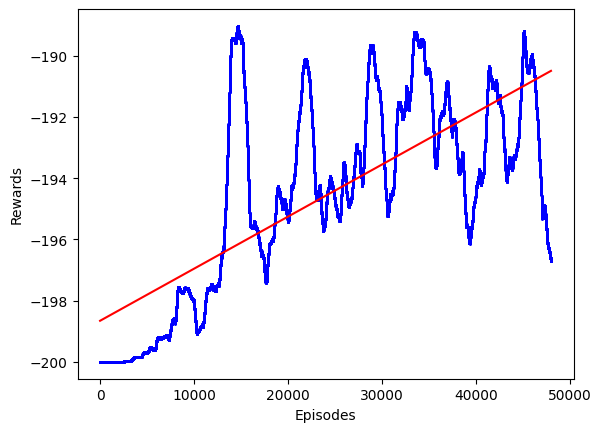

line of best fit equation: 0.0002x + -198.6558
Average rewards:  -194.7192256154877


In [ ]:
#Learning Curve
graph_performance(TD2_reward)
print("Average rewards: ", np.mean(TD2_reward))

Iterations that were run: 169


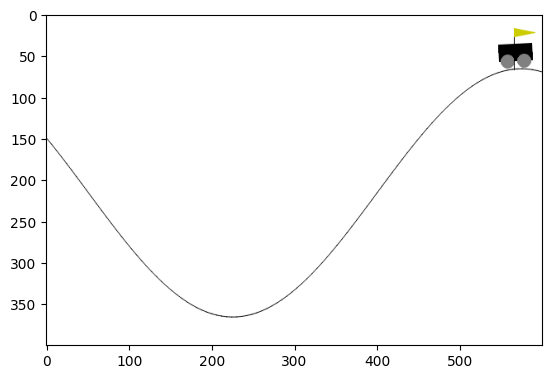

In [ ]:
#Test the learned Policy
Test_performace(Q_TD2)

---

###**TD(3)**

In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_TD3 , TD3_reward = TDn(n = 3, alpha = 0.1, gamma = 0.9, epoch = 50_000, epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1319.45 s


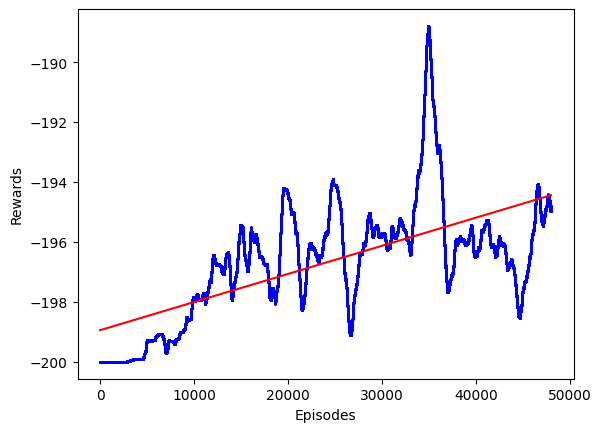

line of best fit equation: 0.0001x + -198.9416
Average rewards:  -196.71460570788585


In [ ]:
#Learning Curve
graph_performance(TD3_reward)
print("Average rewards: ", np.mean(TD3_reward))

Iterations that were run: 166


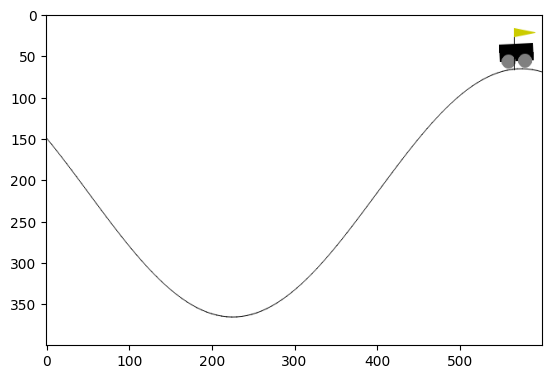

In [ ]:
# Testing the Learned Policy
Test_performace(Q_TD3)

---

###**TD(4)**

In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_TD4 , TD4_reward = TDn(n = 4, alpha = 0.1, gamma = 0.9, epoch = 50_000, epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1326.69 s


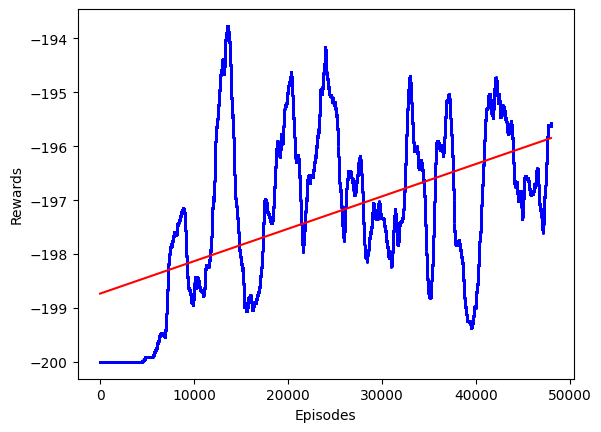

line of best fit equation: 0.0001x + -198.7332
Average rewards:  -197.30789384212315


In [ ]:
#Learning Curve
graph_performance(TD4_reward)
print("Average rewards: ", np.mean(TD4_reward))

Iterations that were run: 181


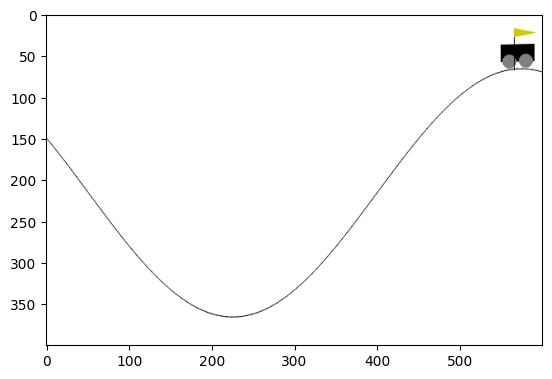

In [ ]:
#Testing the Learned Policy
Test_performace(Q_TD4)

### **Comparison/Analysis**

The table below displays the training time, the slope of the line of best fit and the average reward collected during the tarining of the model.
```
Controller | Training Time(s) |   Slope  | Avg reward |
–––––––––––––––––––––––––––––––––––––––––––––––––––––––
SARSA      |    1228.29       |  0.0002  |   -192.87
           |                  |          |
ESARSA     |    1235.87       |  0.0005  |   -189.24
           |                  |          |
Q-Learning |    1780.01       |  0.0004  |   -191.84
           |                  |          |
TD(2)      |    1316.0        |  0.0002  |   -194.72
           |                  |          |
TD(3)      |    1298.91       |  0.0001  |   -196.71
           |                  |          |
TD(4)      |    1328.39       |  0.0001  |   -197.3

```

The TD(n) functions are n-step SARSA function, therefore by comparing SARSA with TD(2),TD(3),and TD(4), it can be seen that as n increases the improvement rate decreases. It can also be norice the as n increases the average reward collected decreased.

 By looking at the learning curves it can be seen that the variance of rewards decreased by increasing n.


---

## **Bonus Task 3: Tree Backup**

###**Tree Backup - TD(2)**

In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_TB2, TB2_rewards = Tree_Backup(n = 2, alpha = 0.1, gamma = 0.9, epoch = 50_000, epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1280.05 s


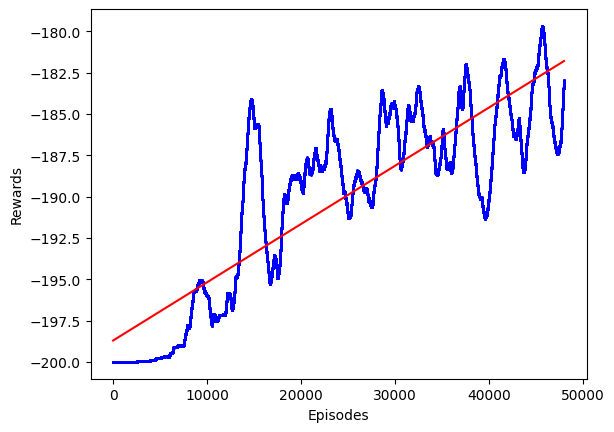

line of best fit equation: 0.0004x + -198.7061
Average rewards:  -190.25233495330093


In [ ]:
#Learning Curve
graph_performance(TB2_rewards)
print("Average rewards: ", np.mean(TB2_rewards))

Iterations that were run: 174


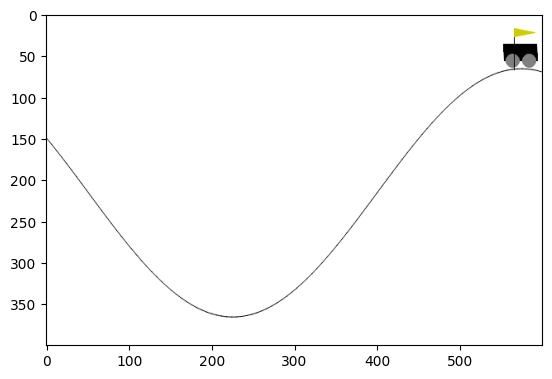

In [ ]:
#Testing the Learned Policy
Test_performace(Q_TB2)

---

###**Tree Backup - TD(3)**

In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_TB3, TB3_rewards = Tree_Backup(n = 3, alpha = 0.1, gamma = 0.9, epoch = 50_000, epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1298.91 s


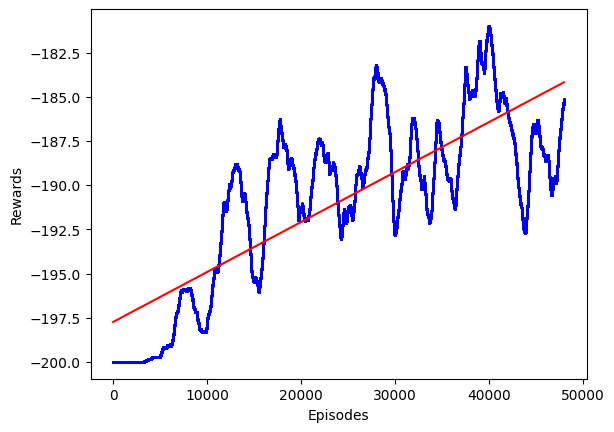

line of best fit equation: 0.0003x + -197.7425
Average rewards:  -191.01721965560688


In [ ]:
#Learning Curve
graph_performance(TB3_rewards)
print("Average rewards: ", np.mean(TB3_rewards))

Iterations that were run: 169


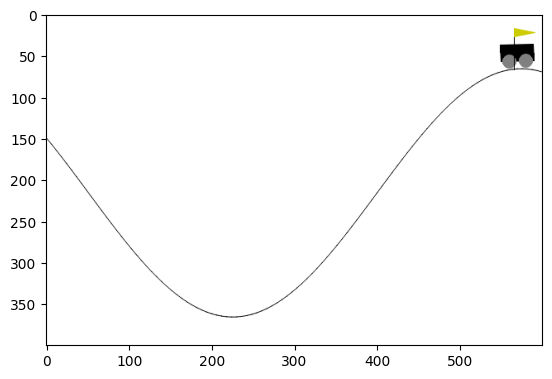

In [ ]:
#Test the Learned Policy
Test_performace(Q_TB3)

---

### **Tree Backup - TD(4)**

In [ ]:
env = gym.make('MountainCar-v0')
start_time = time.time()
Q_TB4, TB4_rewards = Tree_Backup(n = 4, alpha = 0.1, gamma = 0.9, epoch = 50_000, epsilon = 0.2)
end_time = time.time()
print("Elapsed Time: ", round((end_time - start_time),2), 's')

Episode 0
Episode 10000
Episode 20000
Episode 30000
Episode 40000
Episode 50000
Elapsed Time:  1328.39 s


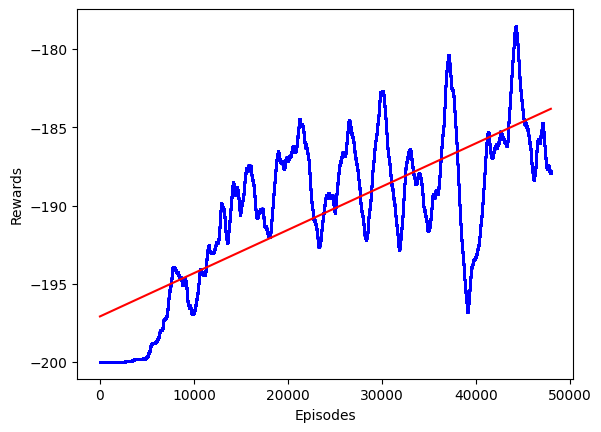

line of best fit equation: 0.0003x + -197.0916
Average rewards:  -190.62632747345054


In [ ]:
#Learning Curve
graph_performance(TB4_rewards)
print("Average rewards: ", np.mean(TB4_rewards))

Iterations that were run: 152


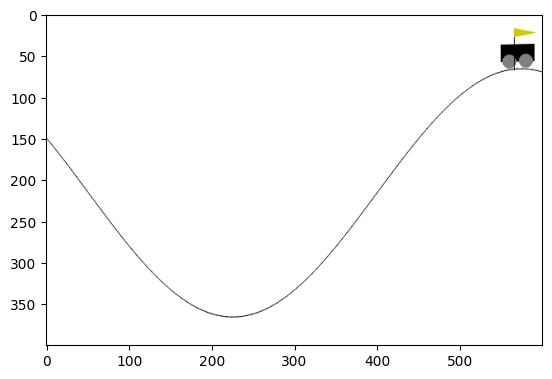

In [ ]:
#Test the Learned Policy
Test_performace(Q_TB4)

### **Comparison/Analysis**

The table below displays the training time, the slope of the line of best fit and the average reward collected during the tarining of the model.

```
Controller | Training Time(s) |   Slope  | Avg reward |
–––––––––––––––––––––––––––––––––––––––––––––––––––––––
TB(2)      |    1280.05       |  0.0004  |   -190.25
           |                  |          |
TB(3)      |    1298.91       |  0.0003  |   -191.02
           |                  |          |
TB(4)      |    1328.39       |  0.0003  |   -190.63
           |                  |          |
TD(2)      |    1316.0        |  0.0002  |   -194.72
           |                  |          |
TD(3)      |    1298.91       |  0.0001  |   -196.71
           |                  |          |
TD(4)      |    1328.39       |  0.0001  |   -197.3

```

By comparing the Temporal differance controller and the Tree backup controller through their respective learning curves, it can be seen that the Tree Backup Controller in all three cases has a higher learning/improvement rate and less noisy.